# **ENGG680 - Introduction to Digital Engineering**
## *Lab Assignment 3: Introduction to Machine Learning (Gradient Descent, Logistic Regression)*

## Preliminary: Certificate of Work


*We, the undersigned, certify that this is our own work, which has been done expressly for this course, either without the assistance of any other party or where appropriate we have acknowledged the work of others. Further, we have read and understood the section in the university calendar on plagiarism/cheating/other academic misconduct and we are aware of the implications thereof. We request that the total mark for this assignment be distributed as follows among group members:*

In [1]:
import pandas as pd

# Define your data
data = {
    "First Name": ["Chan Nyein", "Soheil", "Seyedehshima", "Zohreh"],
    "Last Name": ["Aung", "Seifi", "Moradi", "Mejrisazantoosi"],
    "Signature (Full Name, Date)": ["Chan Nyein Aung, 2024-11-08", "Soheil Seifi, 2024-11-08",
                                     "Seyedehshima Moradi, 2024-11-08", "Zohreh Mejrisazantoosi, 2024-11-08"],
    "Hours": [20, 20, 20, 20],
    "Contribution %": [25, 25, 25, 25]
}

# Create the DataFrame
df = pd.DataFrame(data)

df.index = [f"Member {i+1}" for i in range(len(df))]

# Display the DataFrame
df

,First Name,Last Name,"Signature (Full Name, Date)",Hours,Contribution %
Member 1,Chan Nyein,Aung,"Chan Nyein Aung, 2024-11-08",20,25
Member 2,Soheil,Seifi,"Soheil Seifi, 2024-11-08",20,25
Member 3,Seyedehshima,Moradi,"Seyedehshima Moradi, 2024-11-08",20,25
Member 4,Zohreh,Mejrisazantoosi,"Zohreh Mejrisazantoosi, 2024-11-08",20,25


|          | First Name | Last Name | Signature (Full Name, Date) | Hours | Contribution % |
|----------|------------|-----------|-----------------------------|-------|----------------|
| Member 1: | First Name | Last Name | Signature | Hours | Contribution |
| Member 2: | First Name | Last Name | Signature | Hours | Contribution |
| Member 3: | First Name | Last Name | Signature | Hours | Contribution |
| Member 4: | First Name | Last Name | Signature | Hours | Contribution |


# **Non-linear Gradient Descent (25 marks)**

### **Observations:** Pseudorange [m]

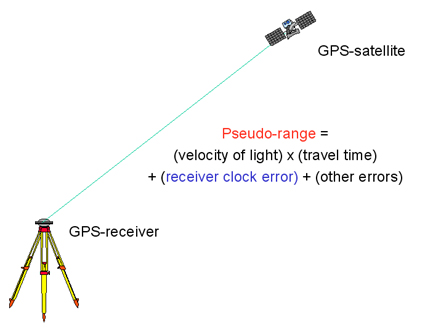

<font size="1.5">Image source: *ICA Course on Toponymy. https://unstats.un.org/unsd/geoinfo/ungegn/docs/_data_icacourses/_HtmlModules/_Selfstudy/S06/S06_05b.html.*</font>

**Pseudorange** is the *pseudo* distance between a satellite and a satellite signal receiver on the ground. In simple words, it contains the geometric range between the satellite and the receiver, with additional associated errors.

The simplified version of the Pseudorange measurement model is:
$$P=\rho-cdT+ϵ_{sum}$$ and
$$\rho=\sqrt{(x_s - x_r)^2 + (y_s - y_r)^2 + (z_s - z_r)^2}$$
where
$$\rho=geometric\ range$$
$${x_s, y_s, z_s, x_r,y_r,z_r} = 3D\ coordinates\ of\ satellite\ and\ receiver$$
$$cdT = receiver\ clock\ offset$$
$$ϵ_{sum}=general\ errors\ term\ (ϵ_{sum}=\Delta \rho + \Delta_{\text{ion}} + \Delta_{\text{trop}} + \epsilon_P + cdt)$$

\\
Note: the 3D **positions of satellites** are given in this assignment.

### **Unknown States:** Position of receiver & receiver clock offset

We use the psuedorange measurements to estimate the receiver's **3-dimensional position** and the **receiver clock offset:** $$X={x_r,y_r,z_r,cdT}$$.

These will be our states of interest, and we are going to estimate them using Gradient Descent method


.

###Step 0: Setup & Intialization

Step 0.1: Import necessary libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os


Step 0.2: Read and parse data files

In [3]:
df_pseudorange = pd.read_excel('/Users/channyeinaung/UOC/ENGO664 Data/Lab/Lab3/engg680_2024_fall/Lab_Assignment3/pseudoranges1.xlsx')
df_sat_pos = pd.read_excel('/Users/channyeinaung/UOC/ENGO664 Data/Lab/Lab3/engg680_2024_fall/Lab_Assignment3/satellite_position1.xlsx')


pseudorange = df_pseudorange['P'].to_numpy()
sat_pos =df_sat_pos[['x','y','z']].to_numpy()

n = pseudorange.size
# print(pseudorange)
# print(sat_pos)

Step 0.3: Define the groundtruth of receiver's position in ECEF (m)

In [4]:
GroundTruth=np.array([-1633489.37967725,	-3651627.18250363,	4952481.61954918])

Step 0.4: Intialize empty arrays

In [5]:
arr_cost= []
arr_grad= []
arr_err=[]
steps_count=0

Step 0.5: Function that
computes the euclidean distance between satellite and receiver

In [6]:
def euclidean_norm(receiver_pos, satellite_pos):

    # Calculate the Euclidean norm (distance)
    distance = np.linalg.norm(satellite_pos - receiver_pos, axis =1)

    return distance


### Step 1: Define the Cost Function (4 marks)
Define a cost function that computes the sum of squared residuals between measured and predicted pseudoranges.

The function's inputs are: the receiver's coordinates, clock offset, satellites' coordinates, observed pseudoranges.

The function returns a single scalar.

Call euclidean_norm function to calculate geometric distance.

In [7]:
# Cost function: sum of squared residuals between measured and predicted pseudoranges
def cost_function(r_pos, cdT, s_pos, pseudorange):
# Useing the euclidean_norm function to compute the geometric distance between receiver and satellites
   predicted_pseudorange = euclidean_norm(r_pos, s_pos) + cdT

# Calculate the residuals (diff between measured and predicted pseudoranges)
   residuals = pseudorange - predicted_pseudorange

# Compute the sum of squared residuals
   L = np.sum(residuals**2)/ n

   return L

### Step 2: Define the Gradient Computation Function (4 marks)

Define a gradient computation function that calculates the gradient of the cost function with respect to the estimates (x_r, y_r, z_r, cdT).


The function's inputs are: the receiver's coordinates, clock offset, satellites' coordinates, observed pseudoranges.


The function returns a 1D numpy array that contains 4 elements.


Call euclidean_norm function to calculate geometric distance.


In [8]:
# Gradient of the cost function with respect to the unknowns (x_r, y_r, z_r, cdT)
def gradient(r_pos, cdT, s_pos, pseudorange):
    n = len(pseudorange)  # Number of satellites
    grad = np.zeros(4)    # Initialize the gradient array

    # Compute the residuals
    predicted_pseudorange = euclidean_norm(r_pos, s_pos) + cdT
    residuals = pseudorange - predicted_pseudorange

    # Loop through each satellite to compute the gradient
    for i in range(n):
        # Derivatives with respect to receiver's position
        diff = r_pos - s_pos[i]
        distance = np.linalg.norm(diff)

        if distance != 0:
            # Update grad[0] (for x_r)
            grad[0] = grad[0] + 2 * residuals[i] * (-diff[0] / distance)

            # Update grad[1] (for y_r)
            grad[1] = grad[1] + 2 * residuals[i] * (-diff[1] / distance)

            # Update grad[2] (for z_r)
            grad[2] = grad[2] + 2 * residuals[i] * (-diff[2] / distance)

    # Partial derivative with respect to cdT (clock bias)
    grad[3] = -2 * np.sum(residuals)

    return grad

### Step 3: Gradient Descent Implementation (4 marks)
Construct the implementation function of gradient descent

Replace '...' with actual implementation

The function's input are: observed pseudoranges, satellites' positions, learning_rate, maximum loop iterations, tolerance

The function will return a 1D numpy array that contains the optimized estimates (x_r, y_r, z_r, cdT)

The function set learning_rate, max_iters and tolerance as: 0.01, 100000, 1e-6 as default values

These default hyperparameters values can be overridden by passing your own values when calling the function


In [9]:
# Gradient descent algorithm for non-linear least squares estimation
def gradient_descent(pseudorange, s_pos, learning_rate=0.01, max_iters=100000, tolerance=1e-6):
    global steps_count

    # Initialize the estimates as zeros (x_r, y_r, z_r, cdT)
    X = np.array([0, 0, 0, 0])

    for iteration in range(max_iters):
        # Extract receiver position and clock offset from X
        r_pos = X[:3]
        cdT = X[3]

        # Compute the cost in the current step
        current_cost = cost_function(r_pos, cdT, s_pos, pseudorange)

        # Compute the gradients in the current step
        grad = gradient(r_pos, cdT, s_pos, pseudorange)

        # Update estimates using gradient descent
        X_new = X - learning_rate * grad

        # Compute the new cost after the update
        new_cost = cost_function(X_new[:3], X_new[3], s_pos, pseudorange)

        # Break the loop if the change in cost is below the tolerance (convergence)
        if np.abs(new_cost - current_cost) < tolerance:
            print("Converged!")
            steps_count = iteration
            break

        # Update the parameters for the next iteration
        X = X_new

        # Collect intermediate results for cost and gradients
        arr_cost.append(current_cost)
        arr_grad.append(grad)
        arr_err.append(X[:3] - GroundTruth)

    return X

### Step 4: Parameters Optimization & Results Printing (3 marks)

Call *gradient_descent* function to optimize the estimating parameters using default optimization hyperparameters

Print:

*   optimized parameters
*   final position errors of receiver
*   number of steps taken for convergence
*   final cost value
*   final gradient values








In [10]:
# Assuming pseudorange, sat_pos, and GroundTruth are already defined

# Call gradient_descent to optimize the parameters
optimized_params = gradient_descent(pseudorange, sat_pos)

# Compute final position error and other metrics
final_gradient = gradient(optimized_params[:3], optimized_params[3], sat_pos, pseudorange)
final_cost = cost_function(optimized_params[:3], optimized_params[3], sat_pos, pseudorange)
final_position_error = optimized_params[:3] - GroundTruth

# Print the results
print("Optimized Parameters (x_r, y_r, z_r, cdT):", optimized_params)
print("Number of Steps Taken for Convergence:", steps_count)
print("Final Gradient Values:", final_gradient)
print("Final Cost Value:", final_cost)
print("Final Position Errors of Receiver:", final_position_error)

Converged!
Optimized Parameters (x_r, y_r, z_r, cdT): [-1.63349244e+06 -3.65162953e+06  4.95248539e+06  6.44954762e+00]
Number of Steps Taken for Convergence: 2700
Final Gradient Values: [ 0.00161511  0.00899931 -0.02765869 -0.0156805 ]
Final Cost Value: 0.563436913173813
Final Position Errors of Receiver: [-3.06252556 -2.346982    3.77353113]


### Step 5: Cost vs Steps Plot & Analysis (2 marks)
Plot cost vs steps

Use 'semilogy' to scale y-axis

Label each axis

Include figure title

Comment on the pattern from the plot

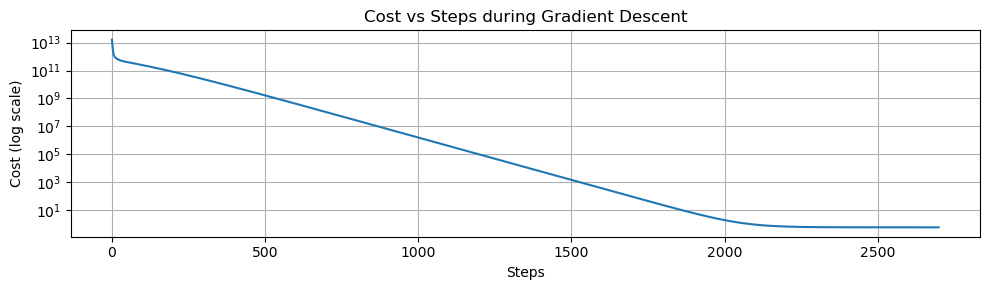

In [11]:
#Cost vs Steps Plot & Analysis
# Create the plot
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 3))

# Plot cost vs. steps using a logarithmic scale for the y-axis
ax.semilogy(arr_cost,)

# Label the axes
ax.set_xlabel('Steps')
ax.set_ylabel('Cost (log scale)')

# Set the title of the plot
ax.set_title('Cost vs Steps during Gradient Descent')

# Enable grid for better visualization
ax.grid(True)

# Adjust layout
fig.tight_layout()

# Show the plot
plt.show()

# Comment on the pattern
# The graph shows an initial decrease in cost, which indicates fast convergence. The flattening curve around 2500 steps suggests convergence or near-optimal performance.


### Step 6: Gradients vs Steps & Analysis(2 marks)
Plot gradients vs steps

use 'symlog' to scale y-axis

use 'tick_params' and set y-axis: labelsize=8

include axes' labels, legends and title

Comment on the pattern from the plot

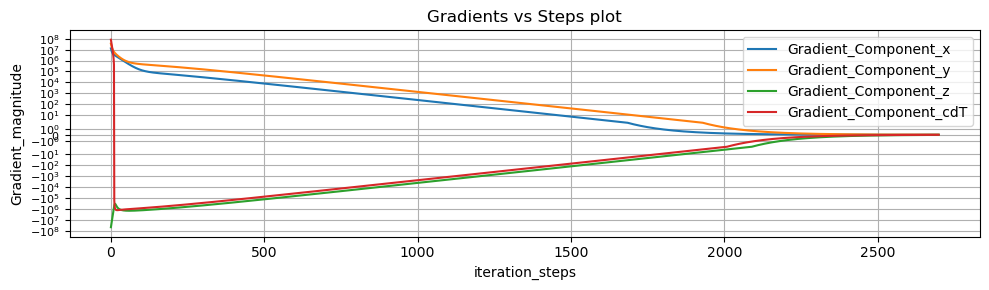

In [12]:

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 3))
ax.plot(arr_grad)

# Set y-axis to symmetric logarithmic scale
ax.set_yscale('symlog')

# Use tick_params to set y-axis label size to 8
ax.tick_params(axis='y', labelsize=8)

# Labels, title, grid, adust layout, legend and show
ax.set_xlabel('iteration_steps')
ax.set_ylabel('Gradient_magnitude')
ax.set_title('Gradients vs Steps plot')
ax.grid(True)
fig.tight_layout()
plt.legend(['Gradient_Component_x', 'Gradient_Component_y', 'Gradient_Component_z', 'Gradient_Component_cdT'])
plt.show()
# Comment on the pattern
#The gradient plot shows how the magnitudes change over time. Ideally, they should decrease, indicating convergence


### Step 7: Positioning errors vs Steps & Analysis(2 marks)
Plot positioning errors vs steps

Include axes' labels, legends and title

Comment on the pattern of the plot

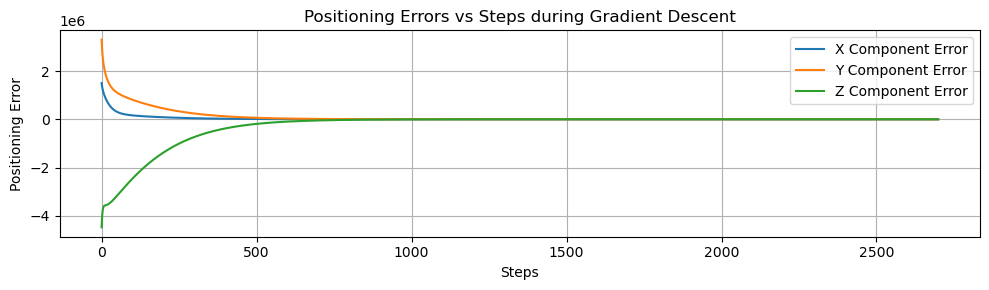

In [13]:
#Positioning errors vs Steps & Analysis)

arr_err = np.array(arr_err)

# Positioning errors vs Steps & Analysis
# Create the plot
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 3))

# Plot positioning errors for each component (x, y, z) vs steps with labels for legend
ax.plot(arr_err[:, 0], label='X Component Error')
ax.plot(arr_err[:, 1], label='Y Component Error')
ax.plot(arr_err[:, 2], label='Z Component Error')

# Label the axes
ax.set_xlabel('Steps')
ax.set_ylabel('Positioning Error')

# Set the title of the plot
ax.set_title('Positioning Errors vs Steps during Gradient Descent')

# Enable grid for better visualization
ax.grid(True)

# Add a legend
ax.legend()

# Adjust layout for better spacing
fig.tight_layout()

# Show the plot
plt.show()


# Comment on the pattern
# Positioning errors typically decrease as the number of steps increases. At the beginning, the errors were large, but as the algorithm converges, the errors in x, y, and z will approach zero or near-zero, indicating that the receiver's position estimate is getting closer to the true position.


# Hyperparameters Tuning

### Step 8: Tuning Learning rate (2 marks)

Change learning rate to 0.01, 0.001 and repeat step 4.

(*hint: you may need to adjust the maximum loop iterations in this case*)

In [14]:
#set learning rate to 0.01
#re-initialize arrays and counters
# learning rate to 0.01 and maximun iteration 150000
results = {}
arr_cost = []   # #re-initializing arrays and counters
arr_grad = []
arr_err = []
steps_count = 0

optimized_params_2 = gradient_descent(pseudorange, sat_pos, learning_rate=0.01, max_iters=150000)
final_position_error = optimized_params_2[:3] - GroundTruth
results[(0.01, 150000)] = {
    "learning_rate": 0.01,
    "max_iters": 150000,
    "optimized_params": optimized_params_2,
    "steps_count": steps_count,
    "final_position_error": final_position_error
}

# Print the metrics for this combination
print("Learning rate: 0.01, Max iterations: 150000")
print(f"Optimized Parameters: {results[(0.01, 150000)]['optimized_params']}")
print(f"Steps Count: {results[(0.01, 150000)]['steps_count']}")
print(f"Final Position Error: {results[(0.01, 150000)]['final_position_error']}")

Converged!
Learning rate: 0.01, Max iterations: 150000
Optimized Parameters: [-1.63349244e+06 -3.65162953e+06  4.95248539e+06  6.44954762e+00]
Steps Count: 2700
Final Position Error: [-3.06252556 -2.346982    3.77353113]


In [15]:
# learning rate to 0.001 and maximun iteration 200000
#re-initialize arrays and counters
results = {}
arr_cost = []     #re-initializing arrays and counters
arr_grad = []
arr_err = []
steps_count = 0

optimized_params_3 = gradient_descent(pseudorange, sat_pos, learning_rate=0.001, max_iters=200000)
final_position_error = optimized_params_3[:3] - GroundTruth
results[(0.001, 200000)] = {
    "learning_rate": 0.001,
    "max_iters": 200000,
    "optimized_params": optimized_params_3,
    "steps_count": steps_count,
    "final_position_error": final_position_error
}

# Print the metrics for this combination
print("Learning rate: 0.001, Max iterations: 200000")
print(f"Optimized Parameters: {results[(0.001, 200000)]['optimized_params']}")
print(f"Steps Count: {results[(0.001, 200000)]['steps_count']}")
print(f"Final Position Error: {results[(0.001, 200000)]['final_position_error']}")

Converged!
Learning rate: 0.001, Max iterations: 200000
Optimized Parameters: [-1.63349244e+06 -3.65162950e+06  4.95248531e+06  6.40077571e+00]
Steps Count: 25431
Final Position Error: [-3.05750202 -2.31899094  3.68750284]


## Step 9: Results Analysis (2 marks)

Q1. Comment on the difference that you notice after changing the learning rate. (1 mark)

Q2. What is the difference between LSE and Gradient Descent? (Comment based on your results and the methodology) (1 mark)



In [16]:
#Answers of the above questions
print("Q1:Changing the learning rate affects convergence speed and stability. A higher rate (0.01) converges faster but can be unstable, while a lower rate (0.001) is slower but more stable.")
print("Q2:LSE provides a direct solution for minimizing errors, while Gradient Descent iteratively approximates the minimum. Gradient Descent is more flexible but depends on learning rate and initial setup.")

Q1:Changing the learning rate affects convergence speed and stability. A higher rate (0.01) converges faster but can be unstable, while a lower rate (0.001) is slower but more stable.
Q2:LSE provides a direct solution for minimizing errors, while Gradient Descent iteratively approximates the minimum. Gradient Descent is more flexible but depends on learning rate and initial setup.


---
---

# **Logistic Regression (50 marks)**

The following dataset helps to predict phishing webpages. It is collected mainly from: PhishTank archive, MillerSmiles archive, Googleâ€™s searching operators.

It can be downloaded from : https://archive.ics.uci.edu/dataset/327/phishing+websites

<u>Class labels:</u>

Not phishing = -1

Phishing = 1



Follow the steps provided to perform binary classification using logistic regression and complete the code for each part.


### Step 0: Import Libraries

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Step 1: Data Input (2 mark)

Use the `fetch_ucirepo(id=<ID>)`  to load the phishing dataset (id = 327) as a dataframe into the feature matrix `X` and target vector `y`.

Print the size of `X` and `y`


In [18]:
!pip install ucimlrepo

In [19]:
from ucimlrepo import fetch_ucirepo

# Below code fetches dataset
phishing_websites = fetch_ucirepo(id=327)

# TO DO: data (as pandas dataframes) (1 mark)
X = pd.DataFrame(phishing_websites['data']['features'])
y = pd.Series(phishing_websites['data']['targets'].values.ravel(), name="target")
# TO DO: display sizes of X and y (1 mark)
print("Size of X:", X.shape)
print("Size of y:", y.shape)

Size of X: (11055, 30)
Size of y: (11055,)


### Step 2.1: Class label histogram (2 marks)

Plot the histogram for each class label to visualise class imbalance. Additionally before calling .show() for the plot, ensure that the code displays you the exact value of the samples for each class above the respective bins.

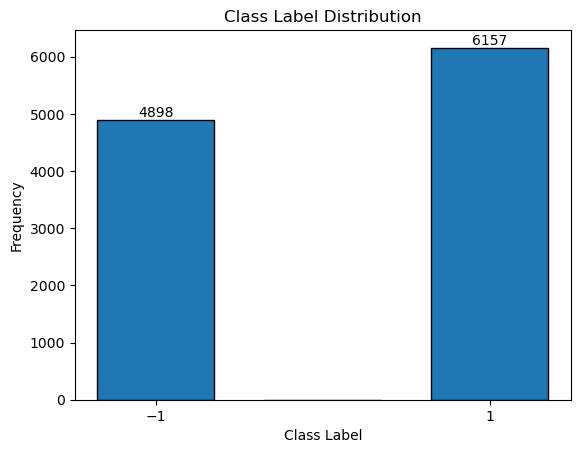

In [20]:
# TO DO: Check the class distribution of y (2 mark)
plt.hist(y, bins=np.arange(-1.5, 2, 1), edgecolor='black', rwidth=0.7)
plt.title('Class Label Distribution')
plt.xlabel('Class Label')
plt.ylabel('Frequency')

# Display exact values for each bin in the histogram
values, counts = np.unique(y, return_counts=True)
for value, count in zip(values, counts):
    plt.text(value, count, str(count), ha='center', va='bottom')

plt.xticks([-1, 1])
plt.show()

### Step 2.2: Smaller dataset creation(2 mark)


We also want to test if the model would still work if we used less data. Use the `train_test_split` function from sklearn to create a new feature matrix named `X_small` and a new target vector named `y_small` that contain **3%** of the data.

Use random_state = 42


In [21]:
from sklearn.model_selection import train_test_split
# TO DO: Create a smaller dataset with 3% of the data
X_small, _, y_small, _ = train_test_split(X, y, test_size=0.97, random_state=42)


# TO DO: display sizes of X_small and y_small (2 mark)
print("Size of X_small:", X_small.shape)
print("Size of y_small:", y_small.shape)

Size of X_small: (331, 30)
Size of y_small: (331,)


### Step 3: Implement Machine Learning Model (6 marks)

1. Import `LogisticRegression` from sklearn
from sklearn.linear_model import LogisticRegression from sklearn.model_selection import train_test_split frtom sklearn.metrics import accuracy_score
2. Instantiate model `LogisticRegression(max_iter=2000)`
model = LogisticRegression(max_iter=2000)
3. Implement the machine learning model with three different datasets:
    - `X` and `y` (1 mark)
    
    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_test=42) model.fit(X_train,y_train)y_pred = model.predict(X_test)
    print("Accuracy with full dataset(X and y):",accuracy_score(y_test,y_pred))

    - Only first two columns of `X` and `y` (1 mark)
    
    X_first_two_cols = X.iloc[:,2]X_train_2,X_test_2,y_train_2,y_test_2 = tarin_test_split(X_first_two_cols,y,test_size=0.3,random_state=42) model.fit(X_train_2,y_train_2)y_pred_2 = model.predict(X_test_2) print("Accuracy with only the first two columns of X:",accuracy_score(y_test_2,y_pred_2))

    - `X_small` and `y_small` (1 mark)
    
    X_train_small,X_test_small,y_train_small,y_test_small = train_test_split(X_small,y_small,test_size=0.3,random_state=42) model.fit(X_train_small,y_train_small) y_pred_small = model.predict(X_test_small) print("Accuracy with smaller dataset (X_small and y_small):",accuracy_score(y_test_small,y_pred_small))

### Step 4: Test Model (6 x 3 = 18 marks)

Calculate the following for the **three different tests** implemented in Step 3
1. data size (1 mark)

Full Dataset = 11,055 samples; Smaller Dataset = approx.331 samples

2. number of training samples (1 mark)

Number of samples used for training - 70% of the data

3. number of testing samples (1 mark)

Number of samples used for testing - 30% of the data

4. training accuracy (1 marks)

The accuracy of the model on the training set 5

5. testing accuracy (1 marks)

The accuracy of the model on the testing set 6

6. log loss (1 mark)

Logarithmic Loss on the testing set which provides a measure of the quality of the model's probability predictions.

### Step 5.1: Visualize Results (3 marks)

1. Create a pandas DataFrame `results` with columns: Data size, training samples, testing samples, training accuracy, testing accuracy, log loss
2. Add these columns for each dataset to the `results` DataFrame
3. Print `results`

For any **random state** parameters from this step onwards, you can use random_state = 0;

In [22]:
#TO DO: Complete steps 3,4, and 5.1 in this code block (Total 27 marks)
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, log_loss

def train_and_evaluate(X, y, test_size=0.3, random_state=0):
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # Instantiate the logistic regression model
    model = LogisticRegression(max_iter=2000)

    # Train the model
    model.fit(X_train, y_train.values.ravel())

    # Predict on training and testing sets
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Calculate accuracy and log loss
    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)

    # Log loss requires probability predictions
    y_train_prob = model.predict_proba(X_train)
    y_test_prob = model.predict_proba(X_test)
    train_log_loss = log_loss(y_train, y_train_prob)
    test_log_loss = log_loss(y_test, y_test_prob)

    # Print results
    print(f"Data size: {X.shape[0]}")
    print(f"Number of training samples: {X_train.shape[0]}")
    print(f"Number of testing samples: {X_test.shape[0]}")
    print(f"Training accuracy: {train_acc:.4f}")
    print(f"Testing accuracy: {test_acc:.4f}")
    print(f"Training log loss: {train_log_loss:.4f}")
    print(f"Testing log loss: {test_log_loss:.4f}")

    # Return a dictionary with results and the necessary arrays
    return {
        'Data Size': X.shape[0],
        'Training Samples': X_train.shape[0],
        'Testing Samples': X_test.shape[0],
        'Training Accuracy': train_acc,
        'Testing Accuracy': test_acc,
        'Log Loss': test_log_loss,
        'y_test': y_test,
        'y_test_pred': y_test_pred
    }
# Create a DataFrame to store results
results = pd.DataFrame(columns=['Data Size', 'Training Samples', 'Testing Samples',
                                'Training Accuracy', 'Testing Accuracy', 'Log Loss'])

# Evaluate for X and y
eval_result = train_and_evaluate(X, y)
results.loc['X and y'] = [eval_result['Data Size'], eval_result['Training Samples'],
                          eval_result['Testing Samples'], eval_result['Training Accuracy'],
                          eval_result['Testing Accuracy'], eval_result['Log Loss']]

# Store y_test and y_test_pred for further analysis
y_test_full = eval_result['y_test']
y_test_pred_full = eval_result['y_test_pred']

# Evaluate for first two columns of X and y
eval_result = train_and_evaluate(X.iloc[:, :2], y)
results.loc['First 2 columns'] = [eval_result['Data Size'], eval_result['Training Samples'],
                                  eval_result['Testing Samples'], eval_result['Training Accuracy'],
                                  eval_result['Testing Accuracy'], eval_result['Log Loss']]

# Evaluate for X_small and y_small
eval_result = train_and_evaluate(X_small, y_small)
results.loc['X_small and y_small'] = [eval_result['Data Size'], eval_result['Training Samples'],
                                      eval_result['Testing Samples'], eval_result['Training Accuracy'],
                                      eval_result['Testing Accuracy'], eval_result['Log Loss']]

# Print the results DataFrame
print("\nResults Summary:")
print(results)





# Note: 70% training set, 30% testing set
# HINT: create a function that calculates all required information

Data size: 11055
Number of training samples: 7738
Number of testing samples: 3317
Training accuracy: 0.9323
Testing accuracy: 0.9228
Training log loss: 0.1765
Testing log loss: 0.1903
Data size: 11055
Number of training samples: 7738
Number of testing samples: 3317
Training accuracy: 0.5628
Testing accuracy: 0.5568
Training log loss: 0.6789
Testing log loss: 0.6836
Data size: 331
Number of training samples: 231
Number of testing samples: 100
Training accuracy: 0.9437
Testing accuracy: 0.9100
Training log loss: 0.1552
Testing log loss: 0.2004

Results Summary:
                     Data Size  Training Samples  Testing Samples  \
X and y                11055.0            7738.0           3317.0   
First 2 columns        11055.0            7738.0           3317.0   
X_small and y_small      331.0             231.0            100.0   

                     Training Accuracy  Testing Accuracy  Log Loss  
X and y                       0.932282          0.922822  0.190326  
First 2 columns    

### Step 5.2: Visualize Classification Errors (6 marks)

In this section, print the confusion matrix and the classification report to investigate the number of false positives vs. false negatives. Use the full dataset for this analysis

In [23]:
# TO DO: Retrieve target vector and predicted values for testing set using full dataset and print the dimension of the predicted output (2 mark)
print("Dimensions of y_test:", y_test_full.shape)
print("Dimensions of y_test_pred:", y_test_pred_full.shape)
# Note: 70% training set, 30% testing set

Dimensions of y_test: (3317,)
Dimensions of y_test_pred: (3317,)


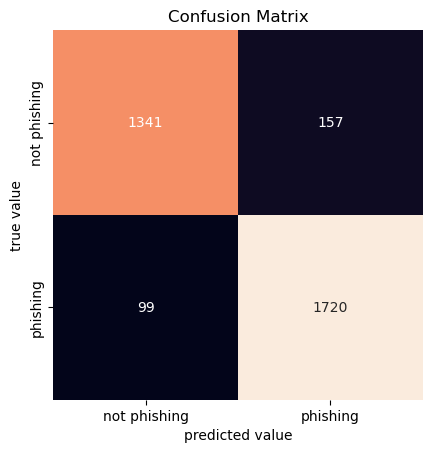

In [24]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# TO DO: Calculate confusion matrix (2 marks) : conf_mat
conf_mat = confusion_matrix(y_test_full, y_test_pred_full)
# Below code prints confusion matrix using a heatmap
sns.heatmap(conf_mat, xticklabels=['not phishing', 'phishing'],  yticklabels=['not phishing', 'phishing'], square=True, annot=True, cbar=False, fmt='d')
plt.xlabel('predicted value')
plt.ylabel('true value')
plt.title('Confusion Matrix')
plt.show()

In [25]:
# TO DO: Print classification report (2 marks)
print(classification_report(y_test_full, y_test_pred_full))


              precision    recall  f1-score   support

          -1       0.93      0.90      0.91      1498
           1       0.92      0.95      0.93      1819

    accuracy                           0.92      3317
   macro avg       0.92      0.92      0.92      3317
weighted avg       0.92      0.92      0.92      3317



### Questions (11 marks)
1. Is the dataset imbalanced? Does it affect model performance? (1 mark)
2. Does the model overfit or underfit for each of the 3 cases? (3 marks)
3. How do the training and testing accuracy change depending on the amount of data used? Explain with values. (1 mark)
4. In this case, what do a false positive and a false negative represent? Which one is worse? (2 marks)
5. Based on your answer to question 4, would you want to maximize precision or recall? How would you do this? (2 marks)
6. Based on the Log Loss for each of the 3 cases, what can you say about the model in each instance? What is potentially causing these differences? (2 mark)


ANSWER HERE







In [26]:
#Answers of the above questions
print('Q1: The dataset is imbalanced, with one class more frequent than the other, which may skew predictions and lower recall for the less common class.')
print('Q2: The model overfits on both the full and smaller datasets, with higher training than testing accuracy, meaning it memorizes patterns instead of generalizing. Using\n only the first two columns, it underfits, as both training and testing accuracies are low, showing it lacks complexity to capture data patterns.')
print('Q3: With more training data, training accuracy may decrease slightly, but test accuracy usually improves, helping the model generalize better and perform well on new data.')
print('Q4:A false positive (FP) is when the model wrongly labels a non-phishing email as phishing, while a false negative (FN) is when it misses an actual phishing email.\n False negatives are more serious here, as missing phishing emails can risk users security.')
print('Q5: To mitigate the risk of false negatives, maximizing recall for the phishing class is recommended. This would make the model more sensitive to phishing, even if\n it results in a slightly higher rate of false positives.')
print('Q6: Log Loss measures the model’s confidence in its predictions, with lower values showing higher confidence and accuracy. Differences in log loss can stem from model complexity, data amount, or class balance.')

Q1: The dataset is imbalanced, with one class more frequent than the other, which may skew predictions and lower recall for the less common class.
Q2: The model overfits on both the full and smaller datasets, with higher training than testing accuracy, meaning it memorizes patterns instead of generalizing. Using
 only the first two columns, it underfits, as both training and testing accuracies are low, showing it lacks complexity to capture data patterns.
Q3: With more training data, training accuracy may decrease slightly, but test accuracy usually improves, helping the model generalize better and perform well on new data.
Q4:A false positive (FP) is when the model wrongly labels a non-phishing email as phishing, while a false negative (FN) is when it misses an actual phishing email.
 False negatives are more serious here, as missing phishing emails can risk users security.
Q5: To mitigate the risk of false negatives, maximizing recall for the phishing class is recommended. This would